In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

img_dir = "images/train/"

csv_file = "products.csv"

products = pd.read_csv("products.csv")

# number search based dictionary for each class
gs1_form_dict = { i:val for i, val in enumerate(list(np.unique(products['GS1 Form'])))}
material_dict = { i:val for i, val in enumerate(list(np.unique(products['Material'])))}
colour_dict = { i:val for i, val in enumerate(list(np.unique(products['Colour'])))}

# Define relevant variables for the ML task
batch_size = 64
num_classes = len(labels_all)
learning_rate = 0.001
num_epochs = 20

# normalizing data ...
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

# Device will determine whether to run the training on GPU or CPU.

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [131]:
"""Loading data with PyTorch"""

from torch.utils.data import DataLoader, Dataset
import random
import os

class MultiLabelDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.img_paths = [str(barcode) + '.jpg' for barcode in self.dataframe['Barcode'].values]
        self.labels = {'GS1 Form':self.dataframe['GS1 Form'].values, 'Material':self.dataframe['Material'].values, 'Colour':self.dataframe['Colour'].values}
        
        # dictionary for each class
        self.gs1_form = { val:i for i, val in gs1_form_dict.items()}
        self.material = { val:i for i, val in material_dict.items()}
        self.colour = { val:i for i, val in colour_dict.items()}
        
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        img = Image.open(img_path).convert('RGB')
        
        # num_classes = len(self.labels_all)
        
        label1 = torch.nn.functional.one_hot(torch.tensor(self.gs1_form[self.labels['GS1 Form'][idx]]), num_classes = len(self.gs1_form))
        label2 = torch.nn.functional.one_hot(torch.tensor(self.material[self.labels['Material'][idx]]), num_classes = len(self.material))
        label3 = torch.nn.functional.one_hot(torch.tensor(self.colour[self.labels['Colour'][idx]]), num_classes = len(self.colour))
        
        if self.transform:
            img = self.transform(img)
        return img, label1, label2, label3
        

"""Currently unused"""

class MultiLabelDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=batch_size, shuffle=False, num_workers=0):
        super(MultiLabelDataLoader, self).__init__(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def __iter__(self):
        for i, (data, label1, label2, label3) in enumerate(super().__iter__()):
            yield (data, label1, label2, label3)

    def __len__(self):
        return len(self.dataset)  

# Create an instance of the custom dataset class
train_dataset = MultiLabelDataset(img_dir, csv_file, transform=transform)

# Create an instance of the custom data loader class
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [133]:
# Define a CNN model

import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(torch.nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(50176, 128)
        self.fc2_1 = nn.Linear(128, 13) # for GS1 Form
        self.fc2_2 = nn.Linear(128, 4) # for Material
        self.fc2_3 = nn.Linear(128, 4) # for Colour

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x1 = self.fc2_1(x) # GS1 Form
        x2 = self.fc2_2(x) # Material
        x3 = self.fc2_3(x) # Colour
        return x1, x2, x3


# Initialize model, loss function and optimizer
model = MultiLabelCNN()

criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.BCEWithLogitsLoss()
criterion3 = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

from tqdm.notebook import tqdm

# Train the model
for epoch in range(num_epochs):
    for i, (images, labels1, labels2, labels3) in enumerate(tqdm(train_loader, desc=(f'Epoch {epoch + 1}'))):
        # Forward pass
        output1, output2, output3 = model(images)
        
        loss1 = criterion1(output1, labels1.float())
        loss2 = criterion2(output2, labels2.float())
        loss3 = criterion3(output3, labels3.float())
        
        loss = loss1 + loss2 + loss3
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    

Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.5445


Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.1793


Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/20], Loss: 1.9454


Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.4331


Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.3460


Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.0647


Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.0254


Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.0447


Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.0365


Epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.0062


Epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.0063


Epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.0632


Epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.0510


Epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.0049


Epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.0045


Epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.0006


Epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.0001


Epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.0000


Epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.0002


Epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.0007


In [134]:
# saving model
torch.save(model.state_dict(), "models/model_batch_20.pth")
print("Saved current model.")

Saved current model.


In [136]:
# loading model
model = MultiLabelCNN()
model.load_state_dict(torch.load("models/model_batch_20.pth"))

<All keys matched successfully>

aerosol metal other-colours 



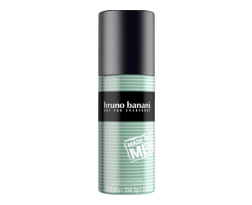

In [161]:
# prediction testing

img_path = 'images/test/test_1.jpg'

img = Image.open(img_path)
img = transform(img)
img = img.view(1, 3, 32, 32)

with torch.no_grad():
    output1, output2, output3 = model(img)
    pred1 = int(torch.argmax(output1, dim=1))
    pred2 = int(torch.argmax(output2, dim=1))
    pred3 = int(torch.argmax(output3, dim=1))

print(gs1_form_dict[pred1], material_dict[pred2], colour_dict[pred3], '\n')

plt.figure(figsize=(3,3))
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()